In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from qutip import *
from IPython.display import HTML

## The quantum harmonic oscillator: brief remarks

The Hamiltonian of the quantum harmonic oscillator in the energy eigenbasis is defined as
$$
\hat{H} = \omega \hat{a}^\dagger \hat{a} \, ,
$$
where $\omega$ is the resonance frequency and $\hat{a}$ is the bosonic annihilation operator.

In [2]:
N = 100 # Hilbert space cutoff
w = 1 # Resonance frequency of the harmonic oscillator

a = destroy(N)

# The Hamiltonian
H = w * a.dag() * a

H

Quantum object: dims=[[100], [100]], shape=(100, 100), type='oper', dtype=Dia, isherm=True
Qobj data =
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 97.  0.  0.]
 [ 0.  0.  0. ...  0. 98.  0.]
 [ 0.  0.  0. ...  0.  0. 99.]]


### Passing in the position basis

We can also express the system in the position basis (eigenstates of the position operator $\hat{x}$), rather than the energy basis. In this way, the position and momentum operators are expressed as ($\hbar = m = 1$):

$$
\hat{x} = \frac{1}{\sqrt{2}} \left( \hat{a} + \hat{a}^\dagger \right)
$$
$$
\hat{p} = i \frac{1}{\sqrt{2}} \left( \hat{a}^\dagger - \hat{a} \right) \, .
$$

We first check that
$$
\left[ \hat{x}, \hat{p} \right] = i
$$

In [3]:
x = (a + a.dag()) / np.sqrt(2)
y = - 1j * (a - a.dag()) / np.sqrt(2)

commutator(x, y)

Quantum object: dims=[[100], [100]], shape=(100, 100), type='oper', dtype=Dia, isherm=False
Qobj data =
[[0. +1.j 0. +0.j 0. +0.j ... 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +1.j 0. +0.j ... 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +1.j ... 0. +0.j 0. +0.j 0. +0.j]
 ...
 [0. +0.j 0. +0.j 0. +0.j ... 0. +1.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j ... 0. +0.j 0. +1.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j ... 0. +0.j 0. +0.j 0.-99.j]]

We now numerically diagonalize the position operator $\hat{x}$, such that $\hat{U}^\dagger \hat{x} \hat{U}$ is diagonal. Then we plot the eigenstates of the quantum harmonic oscillator in the new basis, obtained with
$$
\vert \phi_n (x) \rangle = \hat{U}^\dagger \vert \psi_n \rangle
$$

(0.0, 5.0)

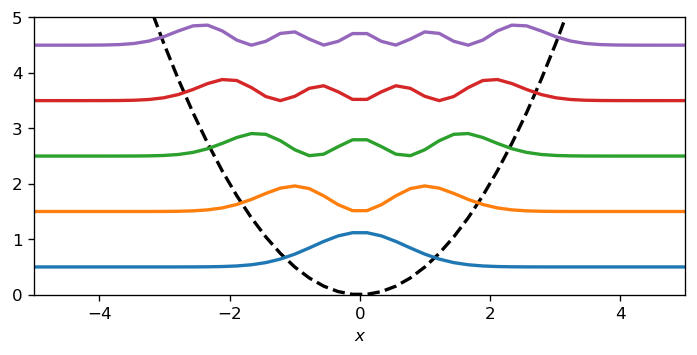

In [4]:
E, T = x.eigenstates()

U = np.zeros((N, N)).astype(np.complex128)
for i in range(N):
    U[:,i] = T[i].full().flatten()

U = Qobj(U)

xlist = ( U.dag() * x * U ).diag()
dx = xlist[1] - xlist[0]

# Harmonic potential
V = w**2 / 2 * xlist**2

fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

ax.plot(xlist, V, color="black", ls="--", lw=2)
for i in range(5):
    factor = 5 # The purpose of this factor is to only make more visible the states
    ax.plot(xlist, factor * np.abs( (U.dag() * fock(N, i)).full() )**2 + i * w + w/2, lw=2)

ax.set_xlabel(r"$x$")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 5)

## Closed Dynamics: The $\text{Schr\"{o}edinger}$ equation

In [5]:
alpha = 3 # Coherence of the initial state

# We start from a coherent state the most classic-like state
psi0 = coherent(N, alpha)

# List of the times for the time evolution
tlist = np.linspace(0, 2 * 2*np.pi/w, 100)

e_ops = [H, a + a.dag()]

sol = sesolve(H, psi0, tlist, e_ops)

### Plot the expectation values

We can access to the expectation values with the command `sol.expect[i]`, where `i` is the index of the $i$-th operator for which we want to calculate te expectation value as a function of time. 

(-6.74682496623539, 16.0)

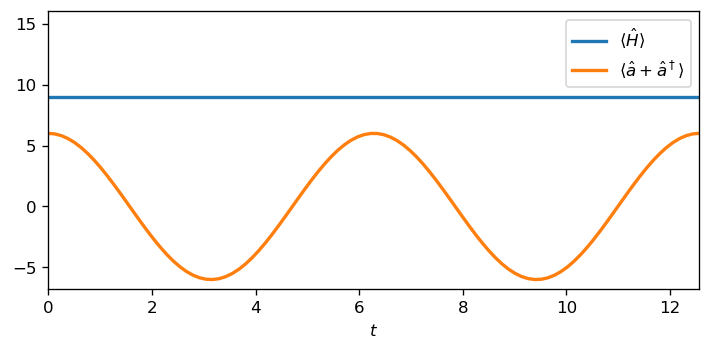

In [6]:
fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

ax.plot(tlist, sol.expect[0], label=r"$\langle \hat{H} \rangle$", lw=2)
ax.plot(tlist, sol.expect[1], label=r"$\langle \hat{a} + \hat{a}^\dagger \rangle$", lw=2)
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_xlim(tlist[0], tlist[-1])
ax.set_ylim(None, 16)

### Access directly to the evolution of the state

We can also access directly to the wavefunction at each `tlist`. This can be done by simply calling `sol.states` to the solver without the `e_ops` operators.

To check this feature, let's see if after $10$ cycles we get still the initial state, by calculating the fidelity
$$
\langle \psi \left(t = 10 T\right) \vert \psi \left( t = 0 \right) \rangle
$$
where $T = \frac{2 \pi}{\omega}$.

In [7]:
sol = sesolve(H, psi0, tlist)

sol.states[0].dag() * sol.states[-1]

(0.9999999999911177-7.446004850969682e-07j)

We then switch to the position eigenbasis. Thus, we need to diagonalize the position operator. This in general involves the _Laguerre_ functions, but here we limit ourselves to numerically diagonalize the position operator.

We now show the wavefunctions in the position basis at three different times: $t_0$, $t_1$ and $t_2$, with
$$
t_0 = 0 \, , \quad t_1 = \frac{\pi}{\omega} \, , \quad t_2 = \frac{2 \pi}{\omega} \, ,
$$
showing the exact periodicity of thi system.

(0.0, 120.0)

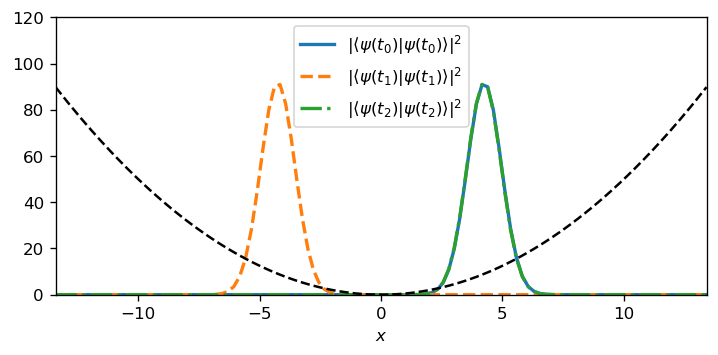

In [8]:
idx_t0 = 0
idx_t1 = np.where(tlist >= np.pi/w)[0][0]
idx_t2 = np.where(tlist >= 2*np.pi/w)[0][0]

psi0_x = U.dag() * sol.states[idx_t0]
psi1_x = U.dag() * sol.states[idx_t1]
psi2_x = U.dag() * sol.states[idx_t2]

fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

ax.plot(xlist, 700 * np.abs(psi0_x.full())**2, label=r"$\vert \langle \psi (t_0) \vert \psi (t_0) \rangle \vert^2$", lw=2)
ax.plot(xlist, 700 * np.abs(psi1_x.full())**2, label=r"$\vert \langle \psi (t_1) \vert \psi (t_1) \rangle \vert^2$", ls="--", lw=2)
ax.plot(xlist, 700 * np.abs(psi2_x.full())**2, label=r"$\vert \langle \psi (t_2) \vert \psi (t_2) \rangle \vert^2$", ls="-.", lw=2)
ax.plot(xlist, V, color="black", ls="--")
ax.legend()
ax.set_xlabel(r"$x$")
ax.set_xlim(xlist[0], xlist[-1])
ax.set_ylim(0, 120)

We can also export an animation, showing more easily the time evolution of the state

In [9]:
fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

line, = ax.plot(xlist, 700 * np.abs(psi0_x.full())**2, lw=2)
ax.plot(xlist, V, color="black", ls="--")
ax.set_xlabel(r"$x$")
ax.set_xlim(xlist[0], xlist[-1])
ax.set_ylim(0, 120)

plt.close(fig) # Otherwise the static figure also appears

def update(frame):
    psi_t = U.dag() * sol.states[frame]
    line.set_ydata( 700 * np.abs(psi_t.full())**2 )
    return line,

fps = 25
ani = FuncAnimation(fig, update, frames=len(tlist), blit=True, interval=1000 / fps)

HTML(ani.to_html5_video())

What happens if we start from the superposition state
$$
\vert \psi (0) \rangle = \frac{1}{\sqrt{2}} \left( \vert 2 \rangle + \vert 5 \rangle \right)
$$

In [10]:
psi0 = (fock(N, 2) + fock(N, 5)).unit()

# List of the times for the time evolution
tlist = np.linspace(0, 2 * 2*np.pi/w, 100)

sol = sesolve(H, psi0, tlist)

fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

line, = ax.plot(xlist, 700 * np.abs(psi0_x.full())**2, lw=2)
ax.plot(xlist, V, color="black", ls="--")
ax.set_xlabel(r"$x$")
ax.set_xlim(xlist[0], xlist[-1])
ax.set_ylim(0, 120)

plt.close(fig) # Otherwise the static figure also appears

def update(frame):
    psi_t = U.dag() * sol.states[frame]
    line.set_ydata( 700 * np.abs(psi_t.full())**2 )
    return line,

fps = 25
ani = FuncAnimation(fig, update, frames=len(tlist), blit=True, interval=1000 / fps)

HTML(ani.to_html5_video())

## Open Dynamics: The Master Equation

In contrast to the closed case, open quantum systems interact with their environment, leading to non-unitary evolution described by the Master equation:

$$
\frac{d \hat{\rho}}{dt} = -\frac{i}{\hbar}[\hat{H}, \hat{\rho}] + \sum_k \left( \hat{L}_k \hat{\rho} \hat{L}_k^\dagger - \frac{1}{2} \{\hat{L}_k^\dagger \hat{L}_k, \hat{\rho}\} \right)
$$

Here, $\hat{\rho}$ represents the density matrix of the system, $\hat{L}_k$ are the Lindblad operators representing different dissipation processes. and $\{\hat{A}, \hat{B} \} = \hat{A} \hat{B} + \hat{B} \hat{A}$ is the anti-commutator between the operators $\hat{A}$ and $\hat{B}$.

(-5.074486183995223, 16.0)

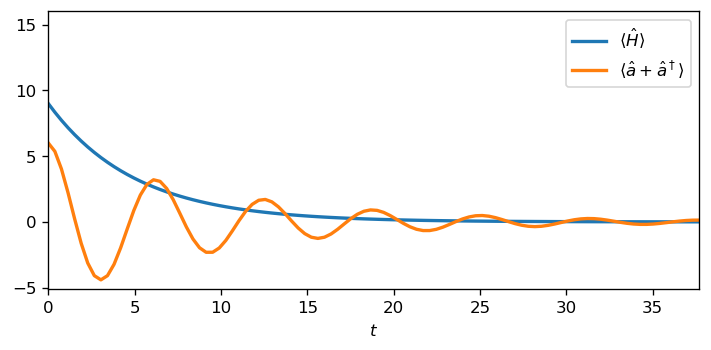

In [11]:
gamma = 0.2 # Decay rate

psi0 = coherent(N, alpha)

c_ops = [np.sqrt(gamma) * a]

tlist = np.linspace(0, 6 * 2*np.pi, 100)

sol = mesolve(H, psi0, tlist, c_ops, e_ops)




fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

ax.plot(tlist, sol.expect[0], label=r"$\langle \hat{H} \rangle$", lw=2)
ax.plot(tlist, sol.expect[1], label=r"$\langle \hat{a} + \hat{a}^\dagger \rangle$", lw=2)
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_xlim(tlist[0], tlist[-1])
ax.set_ylim(None, 16)

## Quantum Trajectories: The Monte Carlo Method

The Monte Carlo quantum trajectories approach simulates open quantum system dynamics by randomly sampling trajectories of the system's state vector. Each trajectory evolves according to a non-Hermitian effective matrix

$$
\hat{H}_\mathrm{eff} = \hat{H} - \frac{i \hbar}{2} \sum_k \hat{L}_k^\dagger \hat{L}_k
$$

Here, the strictly negative non-Hermitian portion gives rise to a reduction in the norm of the wave function. The probability for a quantum junp to occur is then

$$
\delta p = \delta t \sum_k \langle \psi (t) \vert \hat{L}_k^\dagger \hat{L}_k \vert \psi (t) \rangle
$$

Let's consider the fock state $\vert n \rangle$ as the initial state. In this case, the action of the quantum jump is trivial: it makes a jump into the next fock state, losing energy. 

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.07s


(-0.2500000000000001, 6.0)

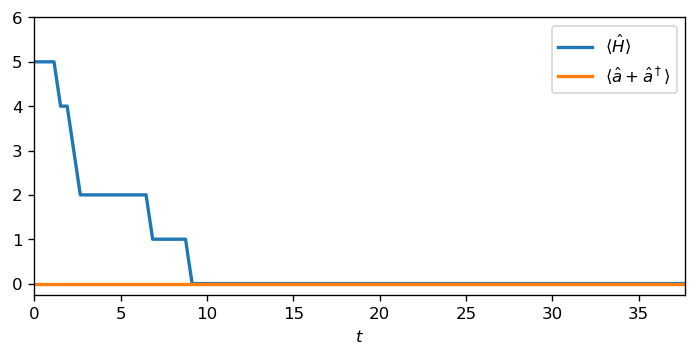

In [12]:
psi0 = fock(N, 5)

c_ops = [np.sqrt(gamma) * a]

tlist = np.linspace(0, 6 * 2*np.pi, 100)

# We perform only one quantum trajectory
sol = mcsolve(H, psi0, tlist, c_ops, e_ops, ntraj=1)

fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

ax.plot(tlist, sol.expect[0], label=r"$\langle \hat{H} \rangle$", lw=2)
ax.plot(tlist, sol.expect[1], label=r"$\langle \hat{a} + \hat{a}^\dagger \rangle$", lw=2)
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_xlim(tlist[0], tlist[-1])
ax.set_ylim(None, 6)

However, if by performing a large number of trajectories and averaging among them, we get the same results as the master equation case.

(-0.25000000000000006, 6.0)

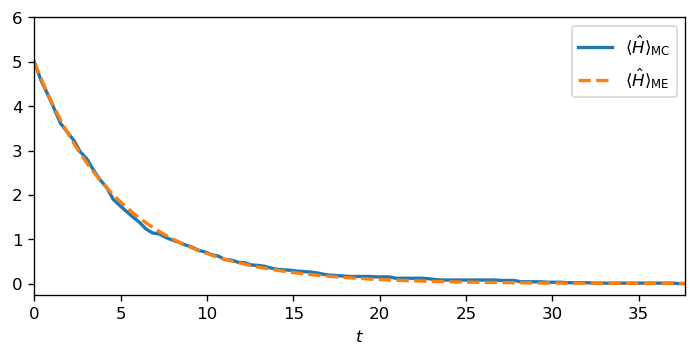

In [15]:
sol_mc = mcsolve(H, psi0, tlist, c_ops, e_ops, ntraj=100)
sol_me = mesolve(H, psi0, tlist, c_ops, e_ops)

fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

ax.plot(tlist, sol_mc.expect[0], label=r"$\langle \hat{H} \rangle_\mathrm{MC}$", lw=2)
ax.plot(tlist, sol_me.expect[0], label=r"$\langle \hat{H} \rangle_\mathrm{ME}$", ls="--", lw=2)
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_xlim(tlist[0], tlist[-1])
ax.set_ylim(None, 6)